# COMP5329 - Deep Learning

## Tutorial 8 - LSTM and GRU

adin6536@uni.sydney.edu.au

anh-dung.dinh@sydney.edu.au

**Semester 1, 2022**

**Objectives:**

* How to implement LSTM and GRU in pytorch
* How to use LSTM, GRU, RNN cell in pytorch
* How to process sequece data by deep learning


**Instructions:**

* Learning to count letter by using RNN, LSTM and GRU


# Sequence data and Time series data

| Sequence data                     | Time series |
| -----------                       | ----------- |
| Any sort of order                 | Time associated order |
| Often used in pattern recognition | Often used for forcasting        |
| Natural Language                  | signal (sound, weather information)|


# Generate sequence data



** Data instruction **
* A-Z, a-z, 0-9
* The differece number between the upper letters and lower letters with some noise.
* 80000 line data, 64000 train data, 16000 validate data

** Example **
* aAA304     -1
* bbB234BbB   0
* ccccccC     5


In [1]:
import random

def generate_line(input_char):
    num1 = random.randint(1, 30)
    num2 = random.randint(1, 30)
    src = [chr(input_char) for _ in range(num1)] # lowercase
    target = [chr(input_char - 32) for _ in range(num2)] # uppercase
    src.extend(target)

    noise_num = random.randint(0, 100)
    for _ in range(noise_num):
        src.append(str(random.randint(0, 9))) # noise number
    random.shuffle(src)

    return ''.join(src), num1 - num2 + 29


def generate_data(size, filename):
    f = open(filename, "w")
    s = set()
    count = 0
    while count < size:
        c = random.randint(ord('a'), ord('z'))
        src, target = generate_line(c)
        if src in s or src[::-1] in s:
            continue
        count += 1
        if count % 10000 == 0:
            print ("generate %d line" % count)
        s.add(src)
        f.write('\t'.join([src, str(target)]))
        f.write('\n')
    f.close()

generate_data(80000, "seq.txt")

generate 10000 line
generate 20000 line
generate 30000 line
generate 40000 line
generate 50000 line
generate 60000 line
generate 70000 line
generate 80000 line


# Model Training
* Create train and val data split
* Zero padding data and map letter to number
* Embedding input to vector
* Feed the RNN/LSTM/GRU with embedding sequence
* Predict the label from the last state of sequence

## Import Pytorch library, and setup global hyperparameters

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

gru_size = 50
hidden_size = 50
embedding_size = 20
input_length = 160
vob_size = 52 + 10 + 1
output_size = 60
gru_keep_prob = 0.5
init_lr_rate = 0.001
# decay_step = 4000
# decay_rate = 0.5
max_gradient_norm = 3

##Define a RNN Model

### RNN cell

$$a^{<t>} = g_1(W_{aa} a^{<t-1>} + W_{ax} x^{<t>} + b_a)$$

$$y^{<t>} = g_2(W_{ya} a^{<t>} + b_y)$$

![image.png](https://stanford.edu/~shervine/teaching/cs-230/illustrations/description-block-rnn-ltr.png?74e25518f882f8758439bcb3637715e5)

### Traditional RNN

One-to-one $T_x = T_y = 1$

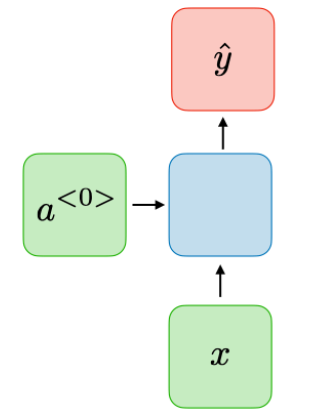

Application: Traditional neural network

### One-to-many
$T_x=1, T_y > 1$

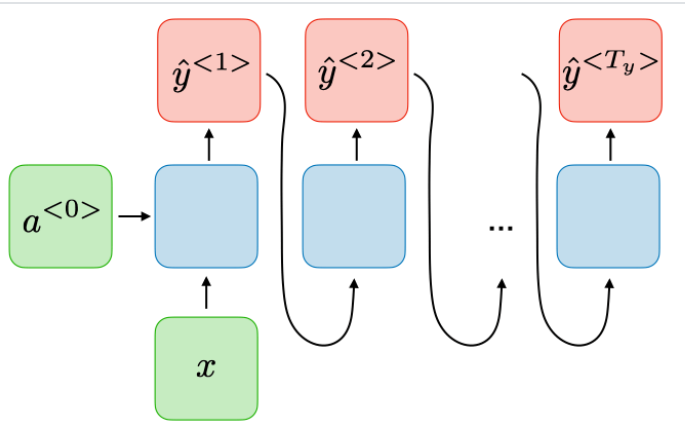

Application: Music generation

### Many-to-one

$T_x > 1, T_y = 1$

![image.png](https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-one-ltr.png?c8a442b3ea9f4cb81f929c089b910c9d)

Application: Classification

### Many-to-Many

$T_x = T_y$

![image.png](https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-many-same-ltr.png?2790431b32050b34b80011afead1f232)

Application: Name entity recognition

### Many-to-many

$T_x \neq T_y$

![image.png](https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-many-different-ltr.png?8ca8bafd1eeac4e8c961d9293858407b)

Appplication: Machine translation

### One example RNN

In [3]:
class RNNModel(nn.Module):
  def __init__(self, in_feature, hidden_size, n_class):
    super(RNNModel, self).__init__()
    self.in_feature = in_feature
    self.hidden_size = hidden_size
    self.n_class = n_class
    self.fully_connected = nn.Linear(in_feature+self.hidden_size, self.hidden_size)
    self.pred_layer = nn.Linear(self.hidden_size, self.n_class)
    self.tanh = nn.Tanh()

  def forward(self, input, dtype=torch.float):
    T = input.shape[0]
    batch_size = input.shape[1]
    outputs = torch.zeros(size=(T, batch_size, self.hidden_size), dtype=dtype)
    state = torch.zeros(size=(batch_size, self.hidden_size), dtype=dtype)

    for t in range(T):
      concat = torch.cat([input[t], state], dim=1)
      state = self.tanh(self.fully_connected(concat))
      outputs[t] = state
    return outputs, state

  def predict(self, input_state, dtype=torch.float):
    _, last_state = self.forward(input_state)
    predict = self.tanh(self.pred_layer(last_state))
    return predict

##Define a LSTM Model

### LSTM Cell

Everything of LSTM is similar to RNN, the main difference is the LSTM cell

![image.png](https://stanford.edu/~shervine/teaching/cs-230/illustrations/lstm-ltr.png?4539fbbcbd9fabfd365936131c13476c)

**Gate**: $Γ = \sigma(W x^{<t>} + U a^{<t-1>} + b)$

We define different gate:


$Γ_{r}$ Relavence gate (candicate cell state)

$$\tilde{c}^{<t>} = \text{tanh}(W_r a^{<t-1>} + U_r x^{<t>} + b_r)$$

$Γ_{o}$ Output gate

$$o^{<t>} = σ(W_{o} a^{<t-1>} + U_{o} x^{<t>} + b_o)$$

$Γ_{f}$ Forget gate

$$f^{<t>} = σ(W_f a^{<t-1>} + U_f x^{<t>} + b_f)$$

$Γ_{u}$ Update gate (Input gate)

$$i^{<t>} = σ(W_{i} a^{<t-1>} + U_{i} x^{<t>} + b_i)$$



**States**

Cell state:

$$c^{<t>} = f^{<t>} * c^{<t-1>} + i^{<t>} * \tilde{c}^{<t>}$$

Output state:

$$a^{<t>} = o^{<t>} * \text{tanh}(c^{<t>})$$

In [4]:
class LSTMModel(nn.Module):
  def __init__(self, in_feature, hidden_size, n_class):
    super(LSTMModel, self).__init__()
    self.in_feature = in_feature
    self.hidden_size = hidden_size
    self.n_class = n_class
    self.fully_connected = nn.Linear(self.in_feature+self.hidden_size, 4 * self.hidden_size)
    self.pred_layer = nn.Linear(self.hidden_size, self.n_class)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, input, dtype=torch.float):
    T = input.shape[0]
    batch_size = input.shape[1]
    outputs = torch.zeros(size=(T, batch_size, self.hidden_size), dtype=dtype)
    c, h = torch.unbind(torch.zeros([2, batch_size, self.hidden_size]), dim=0)
    #implement LSTM forward procedure here
    for t in range(T):
      concat = torch.cat([input[t], h], dim=1)
      states = self.fully_connected(concat)
      it = self.sigmoid(states[:,                       :  self.hidden_size])
      ot = self.sigmoid(states[:,  self.hidden_size     : (self.hidden_size * 2)])
      ft = self.sigmoid(states[:, (self.hidden_size * 2): (self.hidden_size * 3)])
      ctt =   self.tanh(states[:, (self.hidden_size * 3): (self.hidden_size * 4)])

      ct = ft * c + it * ctt
      ht = ot * self.tanh(ct)
      c = ct
      h = ht
      outputs[t] = h
    return outputs, c

  def predict(self, input_state, dtype=torch.float):
    _, last_state = self.forward(input_state)
    predict = self.pred_layer(last_state)
    return predict


##Define a GRU Model


![image.png](https://stanford.edu/~shervine/teaching/cs-230/illustrations/gru-ltr.png?00f278f71b4833d32a87ed53d86f251c)

**Gate**: $Γ = \sigma(W x^{<t>} + U a^{<t-1>} + b)$

We define different gate:


$Γ_{r}$ Relavence gate (reset gate)

$$r^{<t>} = σ(W_r a^{<t-1>} + U_r x^{<t>} + b_r)$$

$Γ_{u}$ Update gate (Input gate + forget gate)

$$z^{<t>} = σ(W_{u} a^{<t-1>} + U_{u} x^{<t>} + b_u)$$


**States**

$$\tilde{a}^{<t-1>} =  r^{<t>} * a^{<t-1>}$$

Candidate cell state

$$a' = \text{tanh}(W_c \tilde{a}^{<t-1>} + U_c x^{<t>} + b_c)$$

Output state

$$a_t = z^{<t>} * a^{<t-1>} + ( 1- z^{<t>}) * a'$$

Cell state

$$c_t = a_t$$


In [5]:
class GRUModel(nn.Module):
  def __init__(self, in_feature, hidden_size, n_class):
    super(GRUModel, self).__init__()
    self.in_feature = in_feature
    self.hidden_size = hidden_size
    self.n_class = n_class
    self.fully_connected_1 = nn.Linear(in_feature+self.hidden_size, 2 * self.hidden_size)
    self.fully_connected_2 = nn.Linear(in_feature+self.hidden_size, self.hidden_size)
    self.pred_layer = nn.Linear(self.hidden_size, self.n_class)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, input, dtype=torch.float):
    T = input.shape[0]
    batch_size = input.shape[1]
    outputs = torch.zeros(size=(T, batch_size, self.hidden_size), dtype=dtype)
    state = torch.zeros(size=(batch_size, self.hidden_size), dtype=dtype)
    # implement GRU forward procedure here
    a = state
    for t in range(T):
      concat = torch.cat([input[t], a], dim=1)
      states = self.fully_connected_1(concat)
      rt = self.sigmoid(states[:,                 :  self.hidden_size])
      zt = self.sigmoid(states[:, self.hidden_size: (self.hidden_size*2)])

      atidle = rt * a
      aprime = self.tanh(self.fully_connected_2(torch.cat([input[t], atidle], dim=1)))

      a = zt * a + ( 1- zt) * aprime
      outputs[t] = a
    return outputs, a

  def predict(self, input_state, dtype=torch.float):
    _, last_state = self.forward(input_state)
    predict = self.pred_layer(last_state)
    return predict



## Setup Dataset, Train and Evaluate Model

In [9]:
import os
import random
import time
import sys
import gc
import numpy as np

MAX_ITERATIONS = 1000
VAL_INTERVAL = 1000
PRINT_INTERVAL = 10
batch_size = 64

def read_dataset(file_name):
    f = open(file_name)
    ls = []
    for line in f.readlines():
        line = line.strip()
        l = line.split('\t')
        ls.append([l[0], int(l[1])])

    random.shuffle(ls)
    return ls[:64000], ls[64000:]


#map letter to number
#a-z -> 1 - 26
#A-Z -> 27 - 52
#0-9 -> 53 - 62
def create_maps():
    dic = {}
    counter = 1
    for i in range(ord('a'), ord('z') + 1):
        dic[chr(i)] = counter
        counter += 1

    for i in range(ord('A'), ord('Z') + 1):
        dic[chr(i)] = counter
        counter += 1

    for i in range(ord('0'), ord('9') + 1):
        dic[chr(i)] = counter
        counter += 1

    return dic

def word_embedding(input_seq, vob_size, dtype=torch.float):
    word_embed = nn.Embedding(vob_size, embedding_size)
    embeddings = word_embed(input_seq.long())
    return embeddings

def create_batch(datas, maps):
    size = len(datas)
    seqs = np.zeros((size, input_length), dtype = np.int32)
    labels = np.zeros(size, dtype = np.int32)
    for i in range(size):
        labels[i] = datas[i][1]
        seq = datas[i][0]
        l = input_length - len(seq) # zero padding
        for j in range(len(seq)):
            seqs[i][l + j] = maps[seq[j]]

    return seqs, labels


def train_model(maps, func_type):
  train_data, val_data = read_dataset("seq.txt")
  pointer = 0
  if func_type == 'rnn':
    model = RNNModel(embedding_size, hidden_size, output_size)
  elif func_type == 'lstm':
    model = LSTMModel(embedding_size, gru_size, output_size)
  elif func_type == 'gru':
    model = GRUModel(embedding_size, gru_size, output_size)
  else:
    print('Please specify a valid model!')
    return
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=init_lr_rate)
  model_loss = nn.CrossEntropyLoss()
  step_time, loss = 0.0, 0.0
  for step in range(MAX_ITERATIONS + 1):
    start_time = time.time()
    if pointer + batch_size >= len(train_data):
      random.shuffle(train_data)
      pointer = 0
    datas = train_data[pointer:pointer + batch_size]
    pointer += batch_size
    input_seq, label = create_batch(datas, maps)
    input_seq, label = torch.from_numpy(input_seq), torch.from_numpy(label)
    seq_emb = word_embedding(input_seq, vob_size)
    input_seq_emb = seq_emb.permute(1,0,2)
    out = model.predict(input_seq_emb)
    step_loss = model_loss(out, label.long())
    optimizer.zero_grad()
    step_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
    optimizer.step()
    end_time = time.time()
    step_time += (end_time - start_time)
    loss += step_loss

    if step % PRINT_INTERVAL == 0:
      step_time = step_time / PRINT_INTERVAL
      loss = loss / PRINT_INTERVAL
      print ("step %d, time %.3f, loss %.3f" % (step, step_time, loss))
      step_time, loss = 0.0, 0.0

    if step % VAL_INTERVAL == 0:
      model.eval()
      val_rate = val_model(model, val_data, maps)
      model.train()
      print("val accuracy is %.3f " % (val_rate))

def val_model(model, dataset, maps):
  start_pointer = 0
  end_pointer = start_pointer + batch_size
  total = 0
  with torch.no_grad():
    while start_pointer < len(dataset):
      datas = dataset[start_pointer: end_pointer]
      start_pointer += batch_size
      end_pointer = min(start_pointer + batch_size, len(dataset))
      input_seq, label = create_batch(datas, maps)
      input_seq, label = torch.from_numpy(input_seq), torch.from_numpy(label)
      seq_emb = word_embedding(input_seq, vob_size)
      input_seq_emb = seq_emb.permute(1,0,2)
      answers = model.predict(input_seq_emb)
      answer_ids = np.argmax(answers.detach().numpy(), axis = -1)
      total += np.sum(label.detach().numpy() == answer_ids)
    return 1.0 * total / len(dataset)

maps = create_maps()
func_type = "lstm" # rnn/lstm/gru
train_model(maps, func_type)





step 0, time 0.016, loss 0.414
val accuracy is 0.020 
step 10, time 0.188, loss 4.092
step 20, time 0.213, loss 4.078
step 30, time 0.155, loss 4.064
step 40, time 0.153, loss 4.067
step 50, time 0.150, loss 4.039
step 60, time 0.154, loss 4.040
step 70, time 0.151, loss 3.992
step 80, time 0.152, loss 3.967
step 90, time 0.196, loss 3.900
step 100, time 0.193, loss 3.909
step 110, time 0.155, loss 3.914
step 120, time 0.163, loss 3.944
step 130, time 0.158, loss 3.938
step 140, time 0.153, loss 3.936
step 150, time 0.161, loss 3.904
step 160, time 0.168, loss 3.948
step 170, time 0.214, loss 3.907
step 180, time 0.155, loss 3.935
step 190, time 0.152, loss 3.933
step 200, time 0.153, loss 3.954
step 210, time 0.147, loss 3.887
step 220, time 0.154, loss 3.910
step 230, time 0.153, loss 3.887
step 240, time 0.190, loss 3.880
step 250, time 0.196, loss 3.901
step 260, time 0.155, loss 3.962
step 270, time 0.156, loss 3.937
step 280, time 0.151, loss 3.929
step 290, time 0.158, loss 3.95

In [11]:
maps = create_maps()
func_type = "gru" # rnn/lstm/gru
train_model(maps, func_type)

step 0, time 0.031, loss 0.414
val accuracy is 0.013 
step 10, time 0.235, loss 4.105
step 20, time 0.205, loss 4.101
step 30, time 0.219, loss 4.101
step 40, time 0.198, loss 4.092
step 50, time 0.212, loss 4.086
step 60, time 0.232, loss 4.067
step 70, time 0.175, loss 4.054
step 80, time 0.176, loss 4.016
step 90, time 0.185, loss 3.969
step 100, time 0.180, loss 3.955
step 110, time 0.182, loss 3.923
step 120, time 0.243, loss 3.897
step 130, time 0.278, loss 3.951
step 140, time 0.190, loss 3.903
step 150, time 0.175, loss 3.912
step 160, time 0.173, loss 3.902
step 170, time 0.179, loss 3.909
step 180, time 0.198, loss 3.916
step 190, time 0.244, loss 3.877
step 200, time 0.179, loss 3.872
step 210, time 0.183, loss 3.894
step 220, time 0.178, loss 3.925
step 230, time 0.178, loss 3.896
step 240, time 0.179, loss 3.927
step 250, time 0.223, loss 3.912
step 260, time 0.207, loss 3.926
step 270, time 0.173, loss 3.906
step 280, time 0.173, loss 3.920
step 290, time 0.177, loss 3.89

KeyboardInterrupt: 

# Exercise
* Implement RNN, LSTM, GRU by basic pytorch function
* Try to adjust parameters in model to achieve better performance